In [1]:
# check the status of gpu
!nvidia-smi

Fri Aug 21 21:24:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
S4_PROJECT_PATH = '/content/drive/My Drive/TSAI/TSAI-2/S4'
sys.path.append(S4_PROJECT_PATH+'/S4_Modular_Code/')
import os
os.chdir(S4_PROJECT_PATH+'/S4_Modular_Code/')

In [4]:
# extracting the raw data
!7z x '/content/drive/My Drive/TSAI/data.7z' -o'/content/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/TSAI/                                       1 file, 293554023 bytes (280 MiB)

Extracting archive: /content/drive/My Drive/TSAI/data.7z
--
Path = /content/drive/My Drive/TSAI/data.7z
Type = 7z
Physical Size = 293554023
Headers Size = 167838
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 4483 - data/train/Rachel_Leigh_Cook                                          1% 5772           2% 5974 - data/train/Alastair_Campbell/Alastair_Campbell_0002.jpg                              

In [4]:
# Imports

from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
from models.inception_resnet_v1 import InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [46]:
!mkdir -p '/content/data_align/train/'

In [47]:
# copying the tenserflow code from repo
# https://github.com/davidsandberg/facenet/tree/master/src/align

%%!
for N in {1..4}; do \
python align_dataset_mtcnn.py '/content/data/train/' '/content/data_align/train/' --image_size 160 --margin 32 --random_order --gpu_memory_fraction 0.25 & done

['Creating networks and loading parameters',
 'Creating networks and loading parameters',
 '2020-08-21 19:40:56.556096: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F',
 'Creating networks and loading parameters',
 '2020-08-21 19:40:56.557698: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F',
 'Creating networks and loading parameters',
 '2020-08-21 19:40:56.559290: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F',
 '2020-08-21 19:40:56.559283: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F',
 '2020-08-21 19:40:56.573406: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 200017999

In [48]:
!mkdir -p '/content/data_align/val/'

In [49]:
# copying the tenserflow code from repo
# https://github.com/davidsandberg/facenet/tree/master/src/align

%%!
for N in {1..4}; do \
python align_dataset_mtcnn.py '/content/data/val/' '/content/data_align/val/' --image_size 160 --margin 32 --random_order --gpu_memory_fraction 0.25 & done

['Creating networks and loading parameters',
 '2020-08-21 19:50:23.574619: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F',
 '2020-08-21 19:50:23.581147: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000179999 Hz',
 '2020-08-21 19:50:23.581620: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b7c53cebc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:',
 '2020-08-21 19:50:23.581671: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version',
 '2020-08-21 19:50:23.596201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1',
 '2020-08-21 19:50:23.695309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one N

In [50]:
# zip back again
!7z a '/content/data_align.7z' '/content/data_align/'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan  /content/                    5772 folders, 13854 files, 481592856 bytes (460 MiB)

Creating archive: /content/data_align.7z

Items to compress: 19626

  0%      0% 57 + data_align/train/Abel_Pacheco/Abel_Pacheco_0001.png                                                               0% 89 + data_align/train/Adam_Ant/Adam_Ant_0001.png                                                       0% 123 + data_align/train/Adrien_Brody/Adrien_Brody_0002.png

In [51]:

%cp -av '/content/data_align.7z' '{S4_PROJECT_PATH}'/

'/content/data_align.7z' -> '/content/drive/My Drive/TSAI/TSAI-2/S4/data_align.7z'


In [5]:
# data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = '/content/data_align'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=1512, 
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['AJ_Cook',
 'AJ_Lamas',
 'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abba_Eban',
 'Abbas_Kiarostami',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullah_al-Attiyah',
 'Abdullatif_Sener',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abhishek_Bachan',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adel_Al-Jubeir',
 'Adelina_Avila',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',


In [6]:
# show images on the console
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

ValueError: ignored

<Figure size 432x288 with 1 Axes>

In [7]:
# Get pretrained ResNet on VGGFace2 dataset
device=torch.device('cuda')
from models.inception_resnet_v1 import InceptionResnetV1
print('Running on device: {}'.format(device))
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes = len(class_names))

Running on device: cuda


In [8]:
# Freeze early layers
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [9]:
# Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [10]:
# Put all beginning layers in an nn.Sequential . model_ft is now a torch model butPut all beginning layers in an nn.Sequential . model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers.Put all beginning layers in an nn.Sequential . model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers. without the final linear, pooling, batchnorm, and sigmoid layers.
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

In [11]:
# training just final layers
for param in model_ft.parameters():
    param.requires_grad = False

In [12]:
# class for last layer
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [13]:
#  final layers back to the new Sequential model
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(layer_list[4].in_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
# Decay LR by a factor of *gamma* every *step_size* epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
# Train the model
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/4
----------
train Loss: 8.6585 Acc: 0.0000
val Loss: 8.6585 Acc: 0.0000
Epoch 1/4
----------
train Loss: 8.6585 Acc: 0.0000
val Loss: 8.6585 Acc: 0.0000
Epoch 2/4
----------
train Loss: 8.6585 Acc: 0.0000
val Loss: 8.6585 Acc: 0.0000
Epoch 3/4
----------
train Loss: 8.6585 Acc: 0.0000
val Loss: 8.6585 Acc: 0.0000
Epoch 4/4
----------
train Loss: 8.6585 Acc: 0.0000
val Loss: 8.6585 Acc: 0.0000
Training complete in 4m 26s
Best val Acc: 0.000000


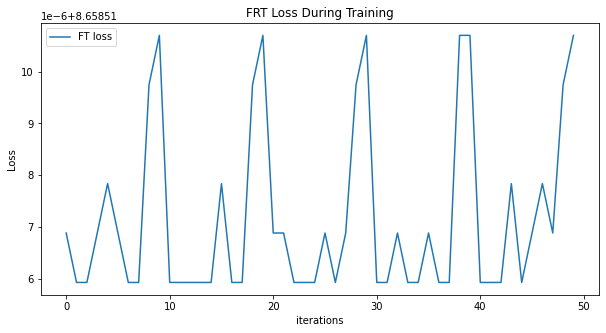

In [15]:
# Evaluate
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
# Evaluate
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 0/49
----------


KeyboardInterrupt: ignored

In [ ]:
from torchsummary import summary
summary(model_ft, input_size=(3,240,240))